In [1]:
import os
os.chdir('../')

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
#import utils
import argparse
import torch.utils.data as data_utils
from torch import nn
from torch import optim
from data_loader.data_loader import create_loader
import trainer
import logger
import copy
import json
import pandas as pd
from sigpyproc.Readers import FilReader as reader
plt.rcParams["figure.figsize"] = (20,10)
import riptide
from riptide import TimeSeries, ffa_search, peak_detection

In [3]:
cuda = 1
np.random.seed(2)
torch.manual_seed(1)  # reproducible
if cuda:
    torch.cuda.manual_seed(1)  # reproducible
device = torch.device("cuda:0" if cuda else "cpu")

In [4]:
def print_input(self, input, output):
    in_array = input[0].detach().cpu().numpy().squeeze()
    print('input', in_array.shape)
    #if len(in_array.shape)>2:
     #   in_array = in_array[0]
    out_array = output[0].detach().cpu().numpy()
    fig0, axs0 = plt.subplots(1,1,figsize=(35, 4))
    #print(out_array.max(), out_array.std())
    if len(in_array.shape) == 1:
        
        im0 = axs0.plot(in_array.squeeze()[0:30000])
        plt.ylim(np.median(in_array)-2, in_array.max()+0.5)
        plt.grid()
        #period = train_net.estimate_period(output[:,0,:])
        #print(period * 0.4709)
    elif len(in_array.shape) == 2:
        #in_array_scrunched = torch.nn.functional.adaptive_avg_pool2d(input[0], (1,128)).detach().cpu().numpy().squeeze()
        if in_array.shape[0] > in_array.shape[1]:
            in_array = in_array.T
        #fig0, axs0 = plt.subplots(1,1,figsize=(35, 4))
        print(in_array.shape, '2d')
        im0 = axs0.imshow(in_array[:,0:230], aspect='auto',vmin=0.0)
        fig0.colorbar(im0, ax=axs0)
        print(np.argmax(np.max(in_array,axis=0)))
        print(np.argmax(np.max(in_array,axis=1)))
        #im1 = axs0[1].plot(in_array_scrunched)
        #print(in_array_scrunched)
        #im1 = axs0[1].imshow(in_array_scrunched, aspect='auto')
        #fig0.colorbar(im1, ax=axs0[1])
    elif len(in_array.shape) == 3:
        if in_array.shape[1] > in_array.shape[2]:
            in_array = np.swapaxes(in_array, 1,2)
        #fig0, axs0 = plt.subplots(1,1,figsize=(35, 4))
        print(in_array.shape, '3d')
        im0 = axs0.imshow(in_array[2,:,:10000], aspect='auto')
        fig0.colorbar(im0, ax=axs0)
    plt.show()

In [18]:
def plot_ffa(tensor, resolution):
    cpu_tensor = tensor.detach().cpu().numpy()
    for i in range(tensor.shape[1]):
        tseries = TimeSeries.from_numpy_array(cpu_tensor[0,i,:], resolution)
        ts, pgram = ffa_search(
                tseries, period_min=0.09, period_max=1.05, bins_min=8, bins_max=20)
        periods = pgram.periods
        snr = pgram.snrs.max(axis=1)
        plt.figure(figsize=(20,5))
        plt.plot(periods, snr, marker='o', markersize=2, alpha=0.5)
        plt.xlim(periods.min(), periods.max())
        plt.xlabel('Trial Period (s)', fontsize=16)
        plt.ylabel('S/N', fontsize=16)

        plt.show()

In [19]:
model = './trained_models/test_model_4_class.pt'
        
model_name = model.split('/')[-1].split('.pt')[0]

file = '/data/lkuenkel/data/PMPS/1997AUGT/downsampled_10_2/PM0019_02561_10_2.fil'

In [20]:
net = torch.load(model)
#net.classifier_stft.conv.register_forward_hook(print_input)
#net.classifier_stft.glob_pool.register_forward_hook(print_input)
#net.classifier_fft_harm_downsample.conv.register_forward_hook(print_input)
#net.classifier_fft_harm_downsample.glob_pool.register_forward_hook(print_input)
dedis_series, combined_class, single_class = net.test_single_file(file, verbose=True)

tensor([[[[4398]]]], device='cuda:0') torch.Size([1, 1, 1890, 10]) 0.006666666666666667 0.006666666666666667
tensor([[[[4486]]]], device='cuda:0') torch.Size([1, 1, 7500, 10]) 0.006666666666666667 0.006666666666666667
tensor([[[[2166]]]], device='cuda:0') torch.Size([1, 1, 7500, 10]) 0.006666666666666667 0.006666666666666667
tensor([[0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[[-70.5407,  69.7613,   0.3417],
         [ -4.3866,   4.6186,   0.6586],
         [-39.3879,  38.2433,   0.3348],
         [-39.8445,  40.6096,   0.6944]]], device='cuda:0',
       grad_fn=<CopySlices>)


In [21]:
combined_class_softmax = torch.nn.Softmax(dim=1)(combined_class[:,:2])
single_class_softmax = torch.nn.Softmax(dim=2)(single_class[:,:,:2])

print(f"Combined Pulsar Prediction: {combined_class_softmax[0,1]}   | Period: combined_class[0,2]")

for i in range(len(net.classifiers)):
    print(f"Single Prediction {net.classifiers[i].name}: {single_class_softmax[0,i,1]}   | Period:   {single_class[0,i,2]}")

Combined Pulsar Prediction: 1.0   | Period: combined_class[0,2]
Single Prediction classifier_stft: 1.0   | Period:   0.3416856527328491
Single Prediction classifier_ffa: 0.9998772144317627   | Period:   0.6585730314254761
Single Prediction classifier_fft: 1.0   | Period:   0.3348214328289032
Single Prediction classifier_fft_harm_downsample: 1.0   | Period:   0.6944443583488464


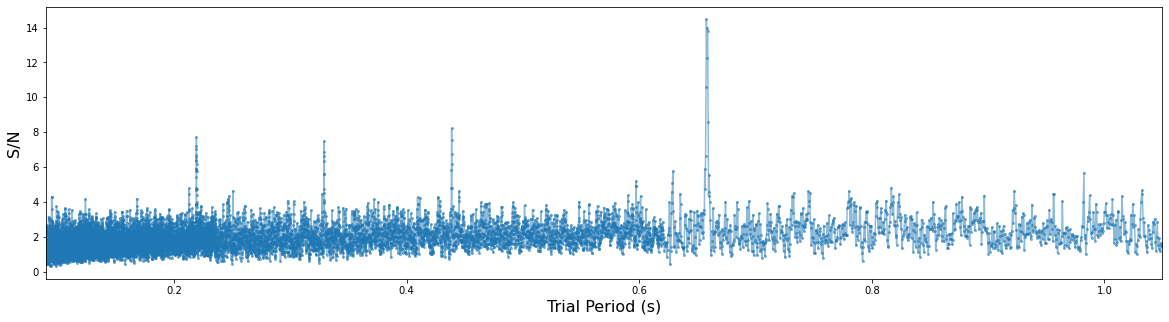

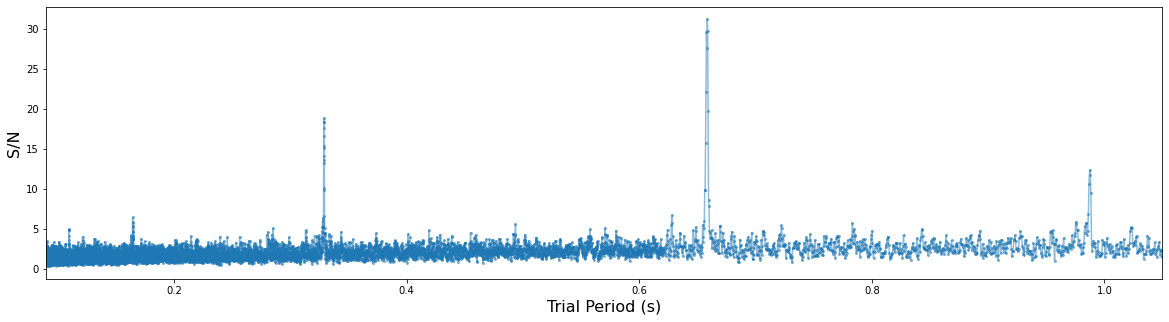

In [22]:
plot_ffa(dedis_series, net.output_resolution)